<a href="https://colab.research.google.com/github/leem928/AI_Project/blob/main/easyOCR%EA%B8%B0%EB%B2%95%EC%99%80%EB%8B%A4%EB%8B%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install easyocr jiwer matplotlib seaborn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 27.6 MB/s eta 0:00:00


In [2]:
import easyocr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jiwer import wer, cer
import os

print("✅ EasyOCR 버전:", easyocr.__version__)
print("✅ NumPy 버전:", np.__version__)

✅ EasyOCR 버전: 1.7.2
✅ NumPy 버전: 2.0.2


In [3]:
import zipfile, os

json_zip_path = "/content/json.zip"
image_zip_path = "/content/images_more.zip"

json_extract_dir = "/content/json"
image_extract_dir = "/content/images_more"

os.makedirs(json_extract_dir, exist_ok=True)
os.makedirs(image_extract_dir, exist_ok=True)

# JSON 압축 해제
with zipfile.ZipFile(json_zip_path, 'r') as zip_ref:
    zip_ref.extractall(json_extract_dir)
print("✅ JSON 압축 해제 완료")

# 이미지 압축 해제
with zipfile.ZipFile(image_zip_path, 'r') as zip_ref:
    zip_ref.extractall(image_extract_dir)
print("✅ 이미지 압축 해제 완료")

# 경로 확인
print("📂 JSON 폴더:", json_extract_dir)
print("📂 이미지 폴더:", image_extract_dir)

✅ JSON 압축 해제 완료
✅ 이미지 압축 해제 완료
📂 JSON 폴더: /content/json
📂 이미지 폴더: /content/images_more


In [4]:
import json
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm

json_dir = "/content/json/json"                 # JSON 폴더
image_dir = "/content/images_more/images_more"      # 원본 이미지 폴더
cropped_dir = "/content/cropped_images"         # 전성분 부분만 crop
os.makedirs(cropped_dir, exist_ok=True)

valid_exts = [".jpg", ".jpeg", ".png"]
image_map = {os.path.splitext(os.path.basename(p))[0]: p
             for ext in valid_exts
             for p in glob(os.path.join(image_dir, f"*{ext}"))}

for file in tqdm(os.listdir(json_dir)):
    if not file.endswith(".json"):
        continue
    json_path = os.path.join(json_dir, file)
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    img_name = data.get("name") or file.replace(".json", ".jpg")
    base_name = os.path.splitext(img_name)[0]

    img_path = None
    for ext in valid_exts:
        candidate = f"{base_name}{ext}"
        if candidate in [os.path.basename(v) for v in image_map.values()]:
            img_path = image_map[base_name]
            break

    if not img_path or not os.path.exists(img_path):
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue

    polygons = []
    for ann in data.get("annotations", []):
        for poly in ann.get("polygons", []):
            if str(poly.get("type")) == "2" and "points" in poly:
                pts = np.array(poly["points"], np.int32)
                polygons.append(pts)

    if not polygons:
        continue

    x_min = min(pt[:,0].min() for pt in polygons)
    y_min = min(pt[:,1].min() for pt in polygons)
    x_max = max(pt[:,0].max() for pt in polygons)
    y_max = max(pt[:,1].max() for pt in polygons)

    h, w = img.shape[:2]
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(w, x_max)
    y_max = min(h, y_max)

    cropped = img[y_min:y_max, x_min:x_max]
    save_path = os.path.join(cropped_dir, os.path.basename(img_path))
    cv2.imwrite(save_path, cropped)

print("✅ type=2 전성분 부분 Crop 완료!")
print(f"📁 저장 경로: {cropped_dir}")

100%|██████████| 100/100 [00:07<00:00, 14.15it/s]

✅ type=2 전성분 부분 Crop 완료!
📁 저장 경로: /content/cropped_images


In [5]:
import pandas as pd

csv_path = "/content/ground_truth.csv"
rows = []

for file in os.listdir(json_dir):
    if not file.endswith(".json"):
        continue
    json_path = os.path.join(json_dir, file)
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    filename = data.get("name") or file.replace(".json", ".jpg")
    gt_texts = []

    for ann in data.get("annotations", []):
        for poly in ann.get("polygons", []):
            if str(poly.get("type")) == "2":
                text = poly.get("text", "").strip()
                if text:
                    gt_texts.append(text)

    if gt_texts:
        rows.append({"filename": filename, "gt_text": " ".join(gt_texts)})

df = pd.DataFrame(rows)
df.to_csv(csv_path, index=False, encoding='utf-8-sig')
print(f"✅ ground_truth.csv 생성 완료 ({len(df)}개 이미지)")

✅ ground_truth.csv 생성 완료 (100개 이미지)


In [6]:
import easyocr
from jiwer import wer, cer
import numpy as np
import pandas as pd
import os

reader = easyocr.Reader(['ko','en'])

image_dir = "/content/cropped_images"
gt_path = "/content/ground_truth.csv"

gt_df = pd.read_csv(gt_path)
results = []

for _, row in gt_df.iterrows():
    fname = row['filename']
    gt_text = str(row['gt_text']).strip()
    base = os.path.splitext(fname)[0]

    img_path = None
    for ext in [".png", ".jpg", ".jpeg"]:
        path = os.path.join(image_dir, f"{base}{ext}")
        if os.path.exists(path):
            img_path = path
            break

    if not img_path:
        continue

    pred = reader.readtext(img_path, detail=0, contrast_ths=0.3, adjust_contrast=0.7)
    pred_text = " ".join(pred).strip()

    cer_val = cer(gt_text, pred_text)
    wer_val = wer(gt_text, pred_text)

    gt_chars, pred_chars = list(gt_text), list(pred_text)
    TP = len(set(gt_chars) & set(pred_chars))
    FP = len(set(pred_chars) - set(gt_chars))
    FN = len(set(gt_chars) - set(pred_chars))
    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)

    results.append({
        "filename": fname,
        "gt": gt_text,
        "pred": pred_text,
        "CER": cer_val,
        "WER": wer_val,
        "Precision": precision,
        "Recall": recall
    })

ocr_df = pd.DataFrame(results)
ocr_df.to_csv("/content/easyocr_eval_results.csv", index=False, encoding='utf-8-sig')
print("✅ EasyOCR 수행 완료 및 결과 저장!")

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.1% Complete✅ EasyOCR 수행 완료 및 결과 저장!


===== 📄 OCR 이미지별 성능 결과 =====


,filename,CER,WER,Precision,Recall
0,cosmetics_00053.jpg,1.167832,2.000000,0.490909,0.760563
1,cosmetics_00282.jpg,0.729412,1.000000,0.644444,0.659091
2,cosmetics_00474.jpg,0.813274,1.089744,0.445545,0.849057
3,cosmetics_00458.jpg,0.953271,1.578947,0.595890,0.836538
4,cosmetics_00082.jpg,0.333333,0.967742,0.686275,0.804598
5,cosmetics_00125.jpg,0.750000,1.117647,0.741935,0.836364
6,cosmetics_00100.jpg,0.297297,0.888889,0.704545,0.746988
7,cosmetics_00416.jpg,0.748366,0.948718,0.760870,0.760870
8,cosmetics_00519.jpg,0.881818,1.106667,0.357724,0.838095
9,cosmetics_00361.jpg,1.000000,1.000000,0.000000,0.000000



===== 📊 평균 성능 =====
평균 CER: 0.8106
평균 WER: 1.1217
평균 Precision: 0.6035
평균 Recall: 0.6985


/tmp/ipython-input-809312164.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=mean_values, palette="coolwarm")
/tmp/ipython-input-809312164.py:39: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-809312164.py:39: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-809312164.py:39: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-809312164.py:39: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-809312164.py:39: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipytho

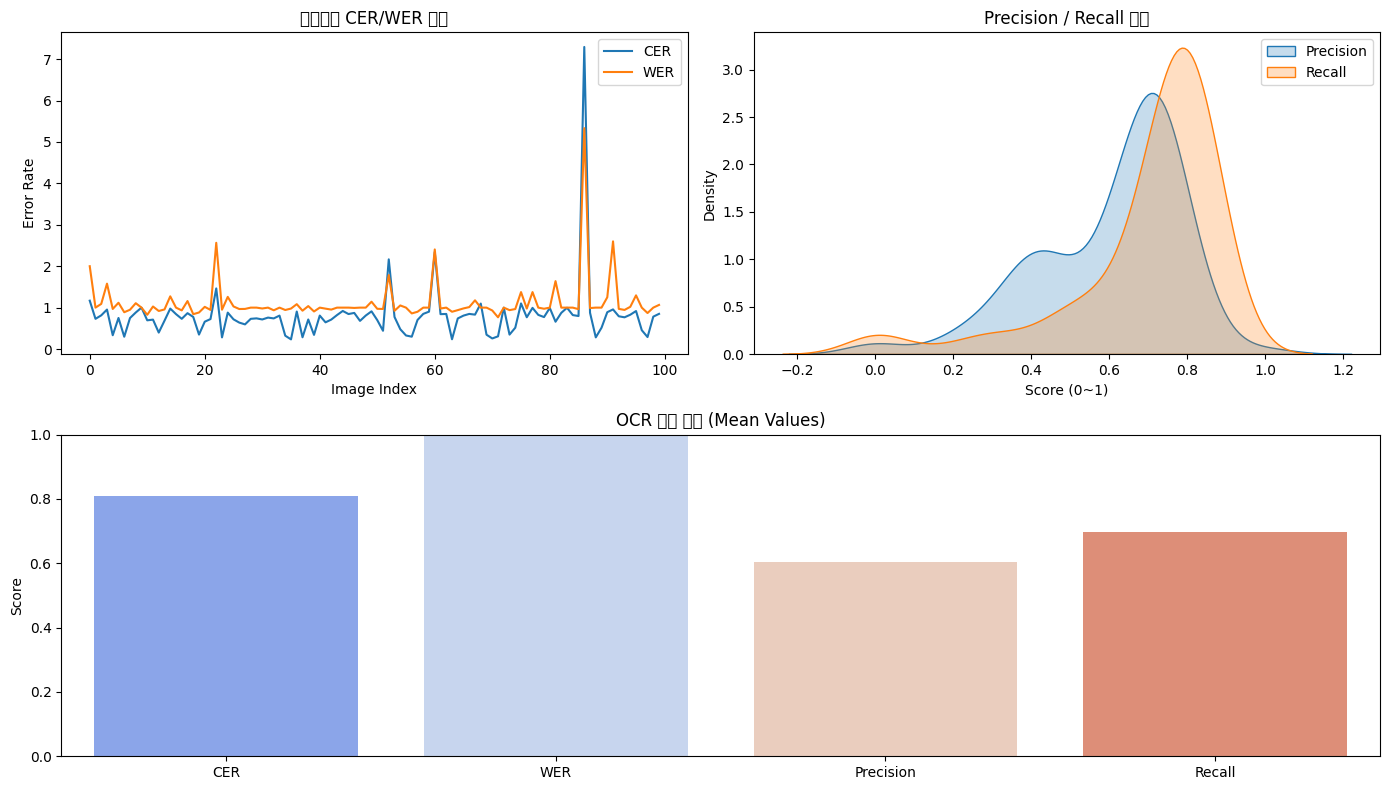

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

print("===== 📄 OCR 이미지별 성능 결과 =====")
display(ocr_df[['filename', 'CER', 'WER', 'Precision', 'Recall']])

print("\n===== 📊 평균 성능 =====")
print(f"평균 CER: {ocr_df['CER'].mean():.4f}")
print(f"평균 WER: {ocr_df['WER'].mean():.4f}")
print(f"평균 Precision: {ocr_df['Precision'].mean():.4f}")
print(f"평균 Recall: {ocr_df['Recall'].mean():.4f}")

plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
sns.lineplot(x=ocr_df.index, y=ocr_df['CER'], label='CER')
sns.lineplot(x=ocr_df.index, y=ocr_df['WER'], label='WER')
plt.title("이미지별 CER/WER 변화")
plt.xlabel("Image Index")
plt.ylabel("Error Rate")
plt.legend()

plt.subplot(2, 2, 2)
sns.kdeplot(ocr_df['Precision'], fill=True, label='Precision')
sns.kdeplot(ocr_df['Recall'], fill=True, label='Recall')
plt.title("Precision / Recall 분포")
plt.xlabel("Score (0~1)")
plt.legend()

plt.subplot(2, 1, 2)
metrics = ['CER', 'WER', 'Precision', 'Recall']
mean_values = [ocr_df[m].mean() for m in metrics]
sns.barplot(x=metrics, y=mean_values, palette="coolwarm")
plt.title("OCR 평균 성능 (Mean Values)")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.tight_layout()
plt.show()

In [8]:
import random
import cv2

print("===== 🧐 OCR 인식 결과 샘플 (상위 10개) =====")
for i, row in ocr_df.head(10).iterrows():
    print(f"📄 파일명: {row['filename']}")
    print(f"✅ 정답(GT): {row['gt'][:200]}")
    print(f"🤖 예측(PRED): {row['pred'][:200]}")
    print(f"📉 CER={row['CER']:.3f}, WER={row['WER']:.3f}, "
          f"Precision={row['Precision']:.3f}, Recall={row['Recall']:.3f}")
    print("-"*100)

print("\n===== ❌ OCR 오류가 큰 이미지 TOP 5 (CER 기준) =====")
worst = ocr_df.sort_values("CER", ascending=False).head(5)
for i, row in worst.iterrows():
    print(f"📄 {row['filename']}")
    print(f"GT  : {row['gt'][:150]}")
    print(f"PRED: {row['pred'][:150]}")
    print(f"CER={row['CER']:.3f}, WER={row['WER']:.3f}")
    print("-"*80)

print("\n===== 🖼️ OCR 인식 결과 시각화 (랜덤 3장) =====")
sample_imgs = random.sample(list(ocr_df['filename']), 3)
plt.figure(figsize=(15, 10))
for i, fname in enumerate(sample_imgs):
    img_path = os.path.join(image_dir, fname)
    if not os.path.exists(img_path):
        continue
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pred_text = ocr_df.loc[ocr_df['filename'] == fname, 'pred'].values[0]
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(f"{fname}\nOCR 인식 결과:\n{pred_text[:80]}...", fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()

worst_one = ocr_df.sort_values("CER", ascending=False).iloc[0]
print("\n===== ❌ OCR 오류가 가장 큰 이미지 =====")
print("📄 파일명:", worst_one['filename'])
print("✅ 정답(GT):", worst_one['gt'])
print("🤖 예측(PRED):", worst_one['pred'])
worst_img_path = os.path.join(image_dir, worst_one['filename'])
if os.path.exists(worst_img_path):
    img = cv2.imread(worst_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("OCR 오류가 가장 큰 이미지", fontsize=12)
    plt.axis("off")
    plt.show()

===== 🧐 OCR 인식 결과 샘플 (상위 10개) =====
📄 파일명: cosmetics_00053.jpg
✅ 정답(GT): 전성분 | 코코넛야자오일, 정제수, 해바라기씨오일, 포도씨오일, 알로에베라추출물, 벤질벤조에이트, 약모밀추출물, 시트로넬올, 스테아릭애씨드, 바질잎가루, 검은깨가루, 라우릭애씨드, ㅗ니추출물(3,000ppm), 마츠리파리아오일,제라니올, 리날룰, 헥실신남알
🤖 예측(PRED): 부  v> 뇨 J_ 중량 (건조전) 7209 (건조후) 100g 제조번호 및 사용기한 | 별도표기 전성분 코코젓야자오일 청제수 해바라기씨오일; 표도씨오일 스테아리야씨드_라우리어세드 노니주출물(3 DoOppm 알로데{라추출물 '말추출물 바칠임가루 검은깨가루 마르리카리아오일 제라니올_리날률_ 벤질렌초에이트 트로)올 핵실신남알 '사용방법 미은수로 피부름 적시고 
📉 CER=1.168, WER=2.000, Precision=0.491, Recall=0.761
----------------------------------------------------------------------------------------------------
📄 파일명: cosmetics_00282.jpg
✅ 정답(GT): 【전성분】 오일, 에틸헥실팔미테이트, 스위트아몬드오일, 올리브오일, 토코페릴아세테이트, 마카다미아씨오일, 호호바씨오일, 에틸헥실글리세린, 향료 코코넛야자
🤖 예측(PRED): [전성문] 에텔엘실팔미테이트 올리보오일 미#다미아오일 흉혼바씨오일 코코넷야자 오일 스위트이본드오일 토로폐랗아세테이트 에텔학실금리세린 향료
📉 CER=0.729, WER=1.000, Precision=0.644, Recall=0.659
----------------------------------------------------------------------------------------------------
📄 파일명: cosmetics_00474.jpg
✅ 정답(GT): 전성분 소듐팔메이트,

<Figure size 1500x1000 with 0 Axes>


===== ❌ OCR 오류가 가장 큰 이미지 =====
📄 파일명: cosmetics_00292.jpg
✅ 정답(GT): 【주요성분】 치오글리콜산 전성분
🤖 예측(PRED): [주요성분]치오글리?산 [호능효과] 제모(체모의제게 [용량-iOmL [포장단위및저장병법]기밀용기 [제조번호 박스 하단에 표시되  [제조연월일] 박스하다표되 (제조일자로일월년도순의로표- [시용기한] 박스하다피되어 (PXP일월년도순의표댐 '전성문
